# 0. 紀錄

**Optimizer 選擇**

SGD :     

|             |precision|    recall|  f1-score|
|-------------|---------|----------|----------|
|    accuracy |         |          |      0.06|
|   macro avg |     0.01|      0.03|      0.01| 
|weighted avg |     0.03|      0.06|      0.03|

Adam : 

|             |precision|    recall|  f1-score|
|-------------|---------|----------|----------|
|    accuracy |         |          |      0.85|
|   macro avg |     0.80|      0.78|      0.79|
|weighted avg |     0.85|      0.85|      0.85|

RMSprop :

|             |precision|    recall|  f1-score|
|-------------|---------|----------|----------|
|    accuracy |         |          |      0.91|
|   macro avg |     0.89|      0.86|      0.87|
|weighted avg |     0.91|      0.91|      0.90|

--------------------------------------------------
**彩色、灰階 or 混合**

灰階 : 

|             |precision|    recall|  f1-score|
|-------------|---------|----------|----------|
|    accuracy |         |          |      0.92|     
|   macro avg |     0.89|      0.87|      0.88|     
|weighted avg |     0.92|      0.92|      0.91| 

混合 : 

|             |precision|    recall|  f1-score|
|-------------|---------|----------|----------|
|    accuracy |         |          |      0.89|     
|   macro avg |     0.88|      0.84|      0.84| 
|weighted avg |     0.90|      0.89|      0.89| 
------------------------------------------------

**灰階+rescale**

|             |precision|    recall|  f1-score|
|-------------|---------|----------|----------|
|    accuracy |         |          |      0.90|     
|   macro avg |     0.88|      0.86|      0.87| 
|weighted avg |     0.91|      0.90|      0.90| 

-> over fitting

-------------------

**灰階+rescale+lr(decay rate = -0.1)+dropout(0.5)**

|             |precision|    recall|  f1-score|
|-------------|---------|----------|----------|
|    accuracy |         |          |      0.94|
|   macro avg |     0.92|      0.91|      0.91|
|weighted avg |     0.94|      0.94|      0.94| 

-------------------------------------------

**灰階+rescale+lr+dropout(0.5)+DA**

使用cv2來調整訓練集圖片的對比度和亮度，同樣轉成灰階，併入原本的訓練集，使訓練集變為2倍。另外使用consine lr decay。

initial_lr = 0.0004,
warmup_epochs = 10,
decay_epochs = 60

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    fill_mode='nearest',
)


|             |precision|    recall|  f1-score|
|-------------|---------|----------|----------|
|    accuracy |         |          |      0.96|
|   macro avg |     0.95|      0.94|      0.95|
|weighted avg |     0.96|      0.96|      0.96| 



# 1. 資料集瀏覽

---
數據集是以 pickle 格式存儲的字典，包含四個鍵/值對：

- `'features'` 是一個4D數組，包含交通標誌圖像的原始像素數據，形狀為 (樣本數, 寬度, 高度, 通道數)。

- `'labels'` 是一維數組，包含交通標誌的類別標籤/ID。文件 `signnames.csv` 包含 ID 到名稱的映射。

- `'sizes'` 是一個列表，包含元組 (寬度, 高度)，表示圖像的原始寬度和高度。

- `'coords'` 是一個列表，包含元組 (x1, y1, x2, y2)，表示圖像中標誌周圍邊界框的坐標。這些坐標假定原始圖像的尺寸。pickle數據包含了這些圖像的調整版本（32x32）

## 從pickle檔案讀取資料集

In [1]:
import pickle

# 定義訓練、驗證和測試數據的文件路徑
training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

# 使用pickle加載數據集
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# 從數據中獲取特徵和標籤
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


## 檢查資料數量

In [2]:
import numpy as np
import random
import pandas as pd

# 計算訓練數據集的數量
n_train = len(X_train)

# 計算驗證數據集的數量
n_valid = len(X_valid)

# 計算測試數據集的數量
n_test = len(X_test)

# 計算交通標誌圖像的形狀
image_shape = [X_train.shape[1], X_train.shape[2], X_train.shape[3]]

# 計算數據集中獨特的類別/標籤數量
def getLabelsCount(labels):
    # 建立一個具有相同長度的初始計數列表，其中每個標籤的初始計數都是 0
    d = dict(zip(labels, [0] * len(labels)))
    for x in labels:
        d[x] += 1
    return d

# 獲取訓練集標籤的計數
signsDicts = getLabelsCount(y_train)
# 計算類別/標籤的數量
n_classes = len(signsDicts)

# 打印摘要信息
print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


## 輸出每一類的一些樣本

In [3]:
# 載入必要的庫
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 在Notebook中顯示圖片
%matplotlib inline

# 定義函數來獲取交通標誌的名稱
def getSignNames():
    return pd.read_csv('./signnames.csv').values

# 定義函數來繪製交通標誌的圖片
def plotImages(X, y, examples_per_sign=15, squeeze=False, cmap=None):
    # 獲取每個交通標誌的樣本數量
    samples_per_sign = np.bincount(y)
    # 遍歷每個交通標誌
    for sign in getSignNames():
        print("{0}. {1} - Samples: {2}".format(sign[0], sign[1], samples_per_sign[sign[0]]))
        # 獲取特定交通標誌的樣本索引
        sample_indices = np.where(y==sign[0])[0]
        # 隨機選取指定數量的樣本
        random_samples = random.sample(list(sample_indices), examples_per_sign)
        # 繪製圖片
        fig = plt.figure(figsize = (examples_per_sign, 1))
        fig.subplots_adjust(hspace = 0, wspace = 0)
        for i in range(examples_per_sign):
            image = X[random_samples[i]]
            axis = fig.add_subplot(1,examples_per_sign, i+1, xticks=[], yticks=[])
            if squeeze: image = image.squeeze()
            if cmap == None: axis.imshow(image)
            else: axis.imshow(image.squeeze(), cmap=cmap)
        plt.show()
        print("----------------------------------------------------------------------------\n")

# 使用定義的函數來繪製訓練數據中的圖片
# plotImages(X_train, y_train)



Bad key "text.kerning_factor" on line 4 in
d:\anaconda3\envs\tf2.5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## 每一類別的數量

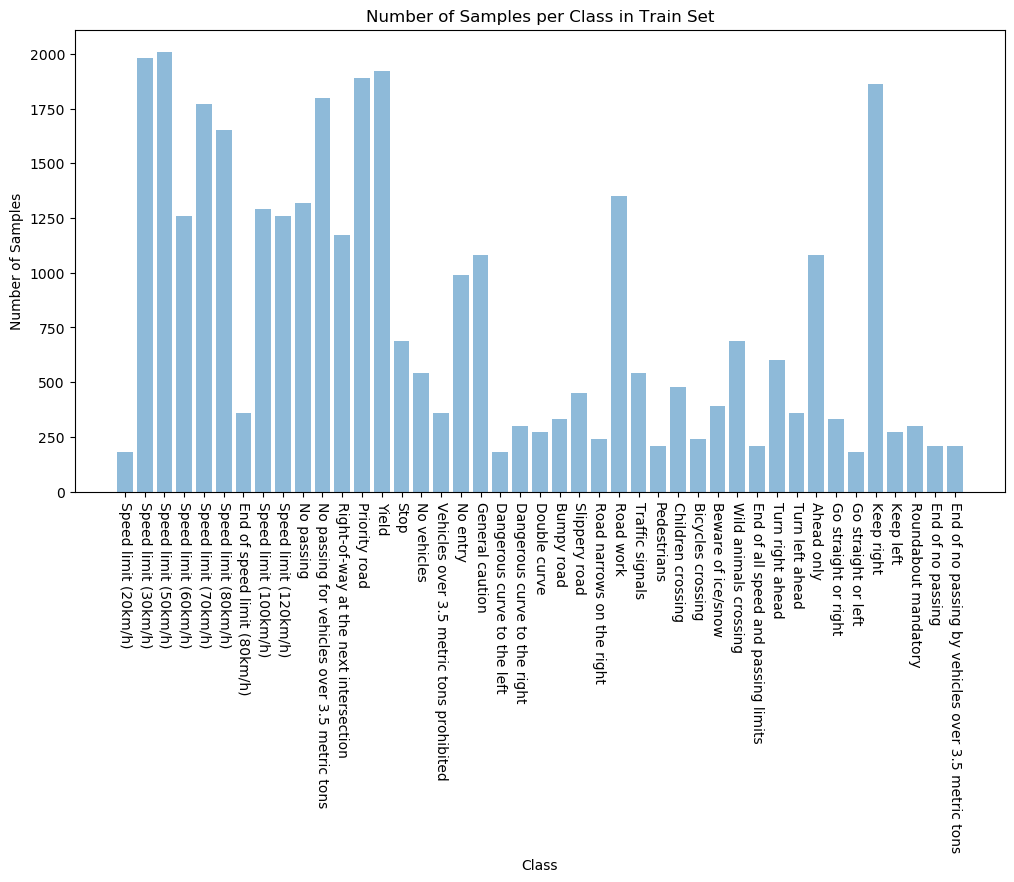

In [4]:
# 設置圖表大小
plt.figure(figsize=(12, 6))  # 調整圖表大小以容納長的類別名稱

# 獲取每個類別的樣本數量
class_counts = np.bincount(y_train)

# 獲取類別名稱
class_names = [name[1] for name in getSignNames()]

# 繪製直方圖
plt.bar(range(n_classes), class_counts, align='center', alpha=0.5)

# 添加標題和標籤
plt.title('Number of Samples per Class in Train Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# 設置 x 軸刻度標籤
plt.xticks(range(n_classes), class_names, rotation=270)  # 將類別名稱設置為 x 軸刻度標籤，並旋轉 90 度以避免重疊

# 顯示圖表
plt.show()



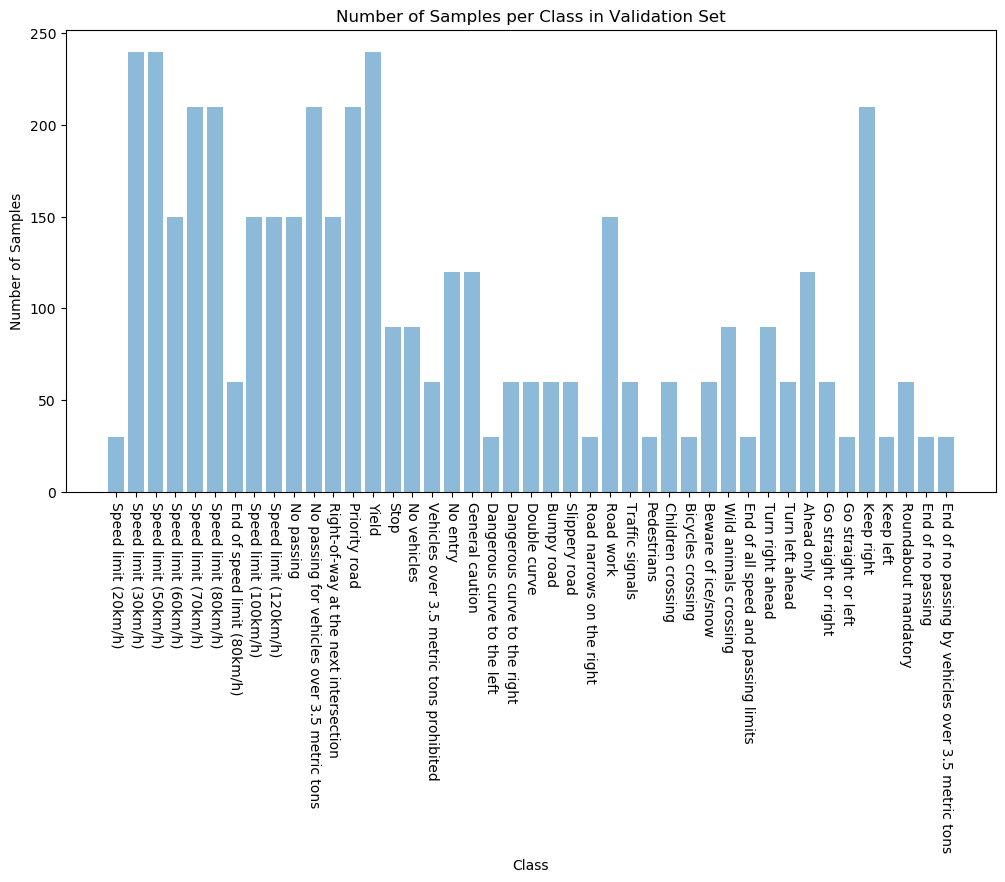

In [5]:
# 設置圖表大小
plt.figure(figsize=(12, 6))  # 調整圖表大小以容納長的類別名稱

# 獲取每個類別的樣本數量
class_counts = np.bincount(y_valid)

# 獲取類別名稱
class_names = [name[1] for name in getSignNames()]

# 繪製直方圖
plt.bar(range(n_classes), class_counts, align='center', alpha=0.5)

# 添加標題和標籤
plt.title('Number of Samples per Class in Validation Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# 設置 x 軸刻度標籤
plt.xticks(range(n_classes), class_names, rotation=270)  # 將類別名稱設置為 x 軸刻度標籤，並旋轉 90 度以避免重疊

# 顯示圖表
plt.show()



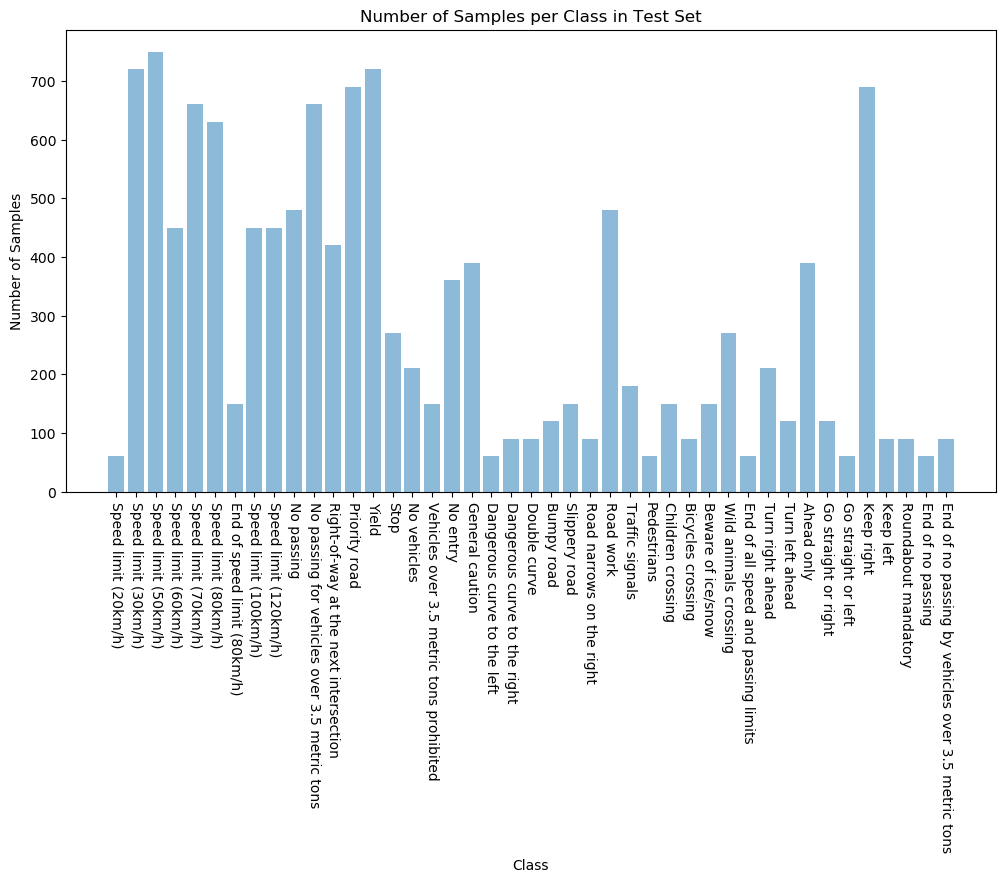

In [6]:
# 設置圖表大小
plt.figure(figsize=(12, 6))  # 調整圖表大小以容納長的類別名稱

# 獲取每個類別的樣本數量
class_counts = np.bincount(y_test)

# 獲取類別名稱
class_names = [name[1] for name in getSignNames()]

# 繪製直方圖
plt.bar(range(n_classes), class_counts, align='center', alpha=0.5)

# 添加標題和標籤
plt.title('Number of Samples per Class in Test Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# 設置 x 軸刻度標籤
plt.xticks(range(n_classes), class_names, rotation=270)  # 將類別名稱設置為 x 軸刻度標籤，並旋轉 90 度以避免重疊

# 顯示圖表
plt.show()



## 隨機顯示一些樣本

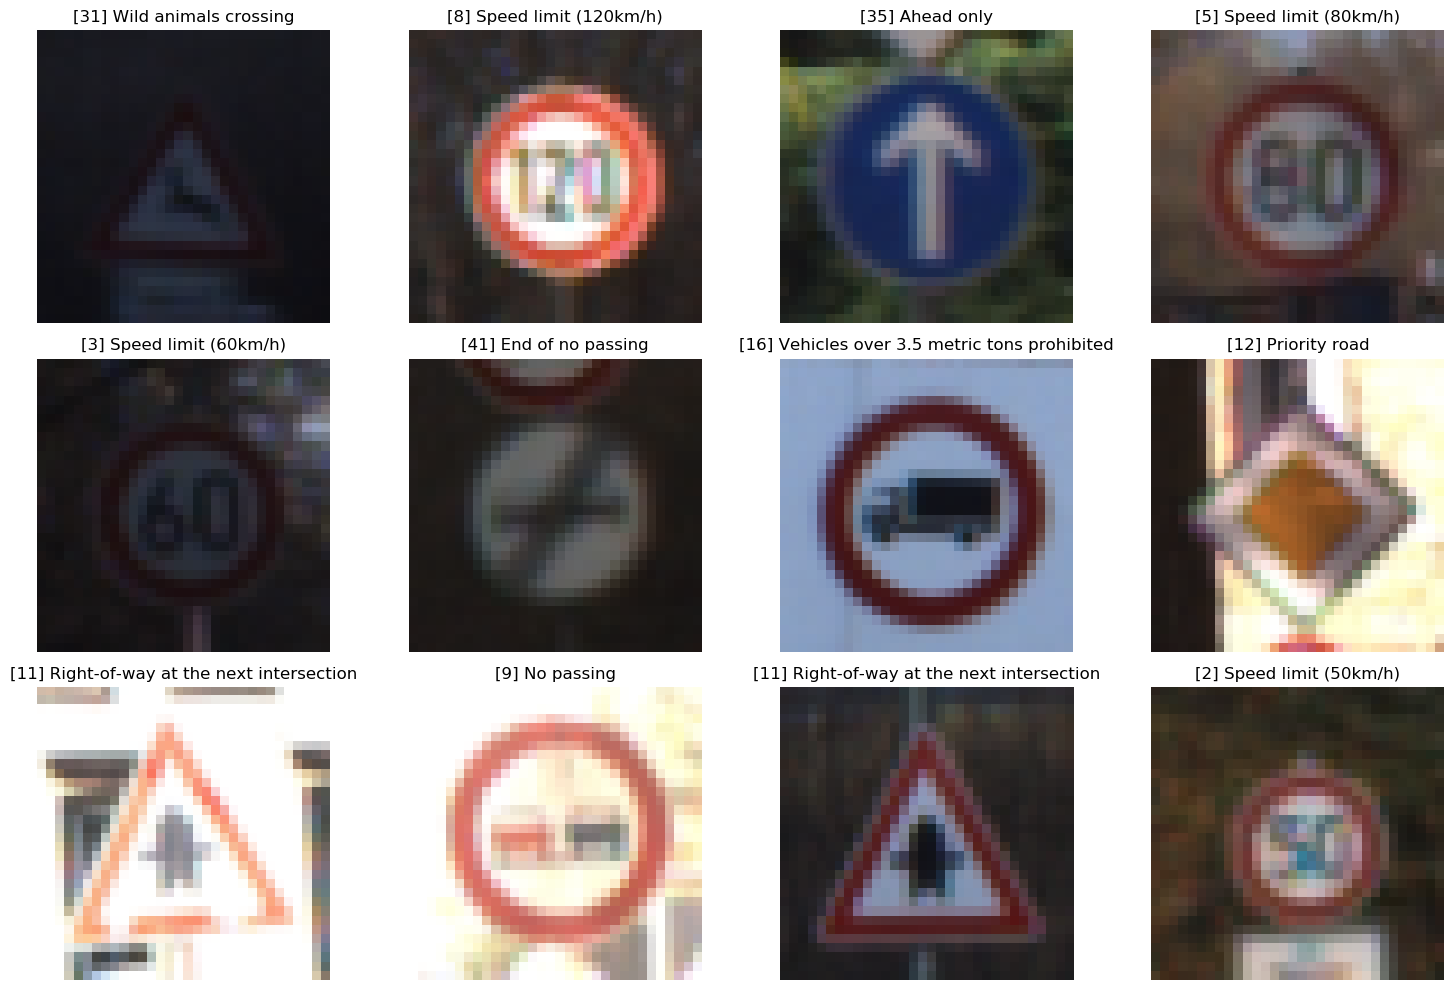

In [8]:
# 獲取訓練數據集的大小
X_train_cnt = len(X_train)

# 取得label名稱列表
label_list  = getSignNames()

# 從訓練數據中隨機選擇多個索引
num_samples = 12
row_num = 3
random_indices = random.sample(range(len(X_train)), num_samples)

# 提取圖像並顯示
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(row_num, num_samples/row_num, i+1)
    image = X_train[index].squeeze()
    plt.imshow(image)
    plt.title(f"[{label_list[y_train[index]][0]}] {label_list[y_train[index]][1]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2. 設計和測試模型架構

## 檢查tensorflow版本和可用gpu

In [9]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# 檢查tensorflow版本
print("tensorflow version : ", tf.__version__)
# 檢查可用gpu
print("GPU available : ", tf.test.is_gpu_available())
# Device list
print(device_lib.list_local_devices())

tensorflow version :  2.5.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available :  True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5753745543137537450
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2236822324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3362162061990254097
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Random Seed set

In [10]:
random_seed = 42
# 設定 numpy 的隨機種子
np.random.seed(random_seed)

# 設定 tensorflow 的隨機種子
tf.random.set_seed(random_seed)

## 打亂訓練集


In [ ]:
from sklearn.utils import shuffle
# 打亂順序
X_train, y_train = shuffle(X_train, y_train, random_state=random_seed)

## 資料前處理

In [ ]:
def data_preprocess(images, color_aug = False):
    # 定義色彩扭曲的函數
    def apply_color_augmentation(image):
        # 對比度增強
        contrast = np.random.uniform(0.5, 2)
        image = cv2.convertScaleAbs(image, alpha=contrast, beta=0)

        # 亮度增強
        brightness = np.random.randint(-10, 10)
        image = cv2.add(image, np.array([brightness]))

        return image

    # 色彩扭曲
    if color_aug :
        augmented_images = np.array([apply_color_augmentation(img) for img in images])
    else : 
        augmented_images = images

    # RGB圖像轉換為灰度圖像
    gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in augmented_images])

    # 在第三個軸位置添加通道維度
    gray = np.expand_dims(gray, axis=3)

    return gray

In [ ]:

X_train_all = np.concatenate((data_preprocess(X_train, color_aug= False),
                             data_preprocess(X_train, color_aug=True)), axis=0)
# X_train_all = data_preprocess(X_train)

X_test_all = data_preprocess(X_test)

X_valid_all = data_preprocess(X_valid)

print(f"X_train_all shape : {X_train_all.shape}")
print(f"X_test_all shape : {X_test_all.shape}")
print(f"X_valid_all shape : {X_valid_all.shape}")


X_train_all shape : (69598, 32, 32, 1)
X_test_all shape : (12630, 32, 32, 1)
X_valid_all shape : (4410, 32, 32, 1)


## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 創建 ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    fill_mode='nearest',
)

# 對訓練集圖像數據進行資料增強
datagen.fit(X_train,seed=random_seed)

## 將 Label 轉換成 One-Hot Encode


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = np.concatenate((y_train,y_train), axis=0)

# 將標籤轉換為 one-hot 編碼
y_train_onehot = to_categorical(y_train, num_classes=43) 
y_valid_onehot = to_categorical(y_valid, num_classes=43)
y_test_onehot = to_categorical(y_test, num_classes=43)

print("y shape :")
print(f"y_train = {y_train_onehot.shape}")
print(f"y_valid = {y_valid_onehot.shape}")
print(f"y_test = {y_test_onehot.shape}")

y shape :
y_train = (69598, 43)
y_valid = (4410, 43)
y_test = (12630, 43)


## LeNet 架構

In [18]:
from tensorflow.keras import layers
# 定義LeNet模型
def LeNet(input_shape, use_rescal = False, 
          use_dropout=False, dropout_rate=0.5):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
   
    # 添加正規化層
    if use_rescal:
        model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))  # 正規化層，將像素值縮放到 [0, 1] 範圍內

    # 第一個卷積層
    # 使用6個5x5的卷積核，激活函數為ReLU，輸入形狀為input_shape
    model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
    
    # 第一個池化層
    # 使用2x2的池化窗口進行最大池化，步幅為2
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # 第二個卷積層
    # 使用16個5x5的卷積核，激活函數為ReLU
    model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
    
    # 第二個池化層
    # 使用2x2的池化窗口進行最大池化，步幅為2
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Dropout
    if use_dropout:
        model.add(layers.Dropout(dropout_rate,))

    # 將多維數組展平為一維
    model.add(layers.Flatten())
    
    # 第一個全連接層
    # 使用120個神經元，激活函數為ReLU
    model.add(layers.Dense(120, activation='relu'))

    # 第二個全連接層
    # 使用84個神經元，激活函數為ReLU
    model.add(layers.Dense(84, activation='relu'))

    # Dropout
    if use_dropout:
        model.add(layers.Dropout(dropout_rate,))
    
    # 輸出層
    # 使用43個神經元，激活函數為softmax，用於多類別分類
    model.add(layers.Dense(43, activation='softmax'))
    
    return model



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0

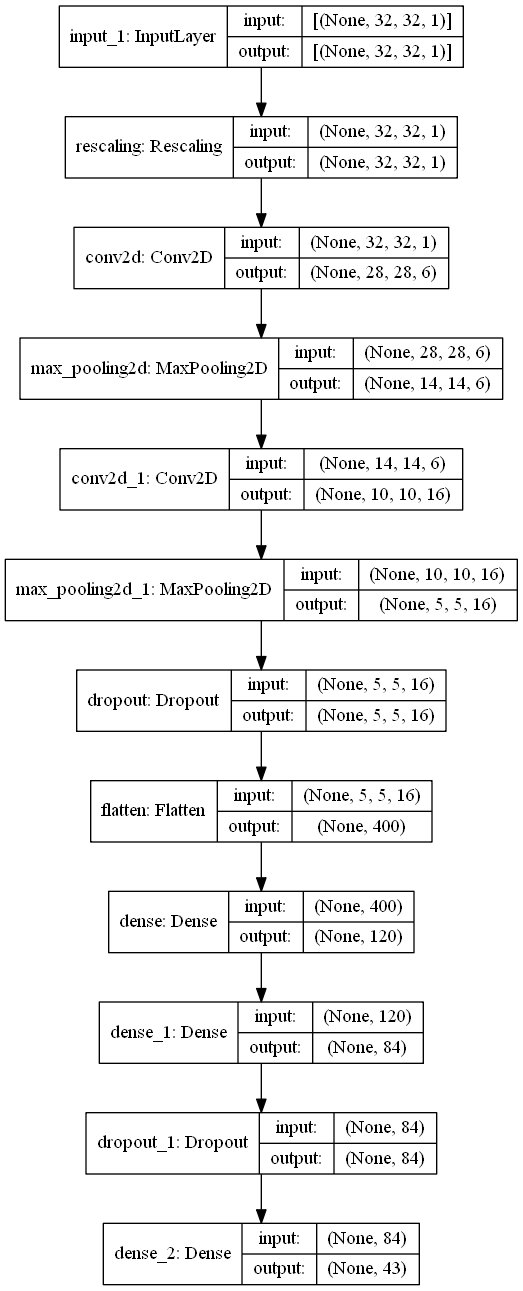

In [19]:
from tensorflow.keras import backend as K
from keras.utils import vis_utils

# 定義輸入圖片大小
input_shape = (32, 32, 1)

# 清除之前的模型和 TensorFlow 圖形
K.clear_session()

# 創建LeNet模型
model = LeNet(input_shape, use_rescal=True, use_dropout=True,dropout_rate=0.5)

# 印出模型摘要
model.summary()

# 繪製模型架構圖
vis_utils.plot_model(model, show_shapes=True, to_file='lenet_model.png')


# 3. 開始訓練 

## 訓練參數設定

In [234]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

model_path = "Model/LeNet_RMSprop_DA.h5"

initial_lr = 0.0004

# 指定優化器
optimizer = RMSprop(learning_rate=initial_lr, momentum=0.9)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


## Callback 設定

In [235]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# 收集學習率值
lr_values = []

### warmup + cosine decay
# 定義 warmup 步驟和餘弦退火的相關參數
warmup_epochs = 10
decay_epochs = 60

# 定義餘弦退火的學習率調度器
def cosine_decay_with_warmup(epoch):
    if epoch < warmup_epochs:
        # 在 warmup 階段線性增加學習率
        lr = initial_lr * (epoch + 1) / warmup_epochs
        
    else:
        # 在餘弦退火階段使用餘弦函數調整學習率
        cos_decay = 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / decay_epochs))
        lr = initial_lr * cos_decay
    lr_values.append(lr)
    return lr

# 創建 LearningRateScheduler 回調函數
lr_scheduler = LearningRateScheduler(cosine_decay_with_warmup)

# 定義 ModelCheckpoint Callback，用於保存具有最佳驗證集表現的模型
checkpoint_callback = ModelCheckpoint(model_path, save_best_only=True)



## 訓練Model

In [236]:
# 模型訓練
# history = model.fit(X_train_all, y_train_onehot, 
#                     epochs=70, batch_size=256, 
#                     validation_data=(X_valid_all, y_valid_onehot),
#                     callbacks=[lr_scheduler, checkpoint_callback])

# 使用生成器訓練模型
history = model.fit(datagen.flow(X_train_all, y_train_onehot, batch_size=256, seed=random_seed),
                    epochs=70,
                    validation_data=(X_valid_all, y_valid_onehot),
                    callbacks=[lr_scheduler, checkpoint_callback])


Epoch 1/70
 28/272 [==>...........................] - ETA: 11s - loss: 3.7450 - accuracy: 0.0371

272/272 [==============================] - 15s 52ms/step - loss: 3.5065 - accuracy: 0.0790 - val_loss: 3.2008 - val_accuracy: 0.1998
Epoch 2/70
272/272 [==============================] - 14s 50ms/step - loss: 2.5815 - accuracy: 0.2964 - val_loss: 1.6491 - val_accuracy: 0.5188
Epoch 3/70
272/272 [==============================] - 14s 50ms/step - loss: 1.6533 - accuracy: 0.5110 - val_loss: 0.8700 - val_accuracy: 0.7685
Epoch 4/70
272/272 [==============================] - 13s 49ms/step - loss: 1.1827 - accuracy: 0.6442 - val_loss: 0.5614 - val_accuracy: 0.8306
Epoch 5/70
272/272 [==============================] - 14s 50ms/step - loss: 0.9213 - accuracy: 0.7188 - val_loss: 0.4139 - val_accuracy: 0.8764
Epoch 6/70
272/272 [==============================] - 14s 50ms/step - loss: 0.7384 - accuracy: 0.7743 - val_loss: 0.3059 - val_accuracy: 0.9150
Epoch 7/70
272/272 [==============================] - 14s 50ms/step - loss: 0.6188 - accuracy: 0.8124 - val_loss: 0.2475 - val_accuracy: 0.9213
Epo

In [237]:
from keras.models import  save_model
save_model(model,model_path)

## 繪製 Loss & Accuracy Curve

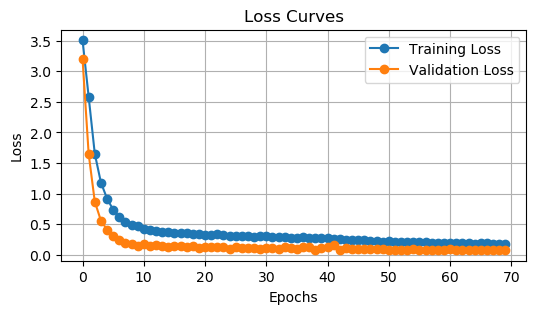

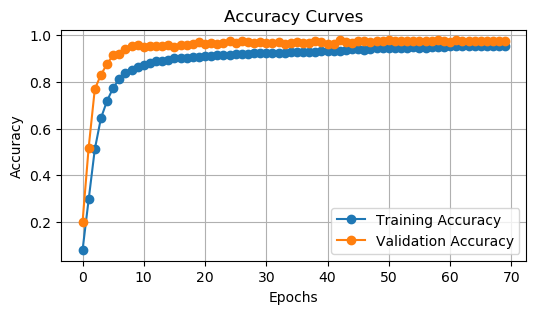

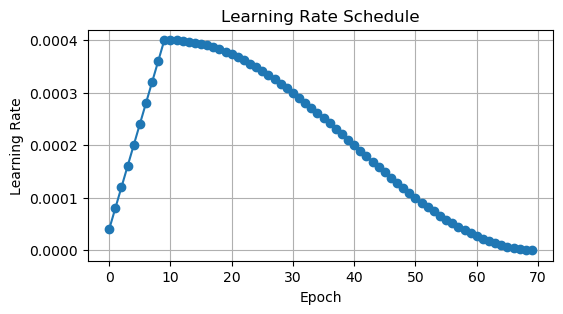

In [238]:
# 取得訓練過程中的損失和準確度
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 繪製損失曲線
plt.figure(figsize=(6, 3))
plt.plot(train_loss, label='Training Loss', marker="o")
plt.plot(val_loss, label='Validation Loss', marker="o")
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # 添加格線
plt.show()

# 繪製準確度曲線
plt.figure(figsize=(6, 3))
plt.plot(train_acc, label='Training Accuracy', marker="o")
plt.plot(val_acc, label='Validation Accuracy', marker="o")
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  # 添加格線
plt.show()

# 繪製學習率曲線
plt.figure(figsize=(6, 3))
plt.plot(lr_values, marker="o")
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)  # 添加格線
plt.show()

# 4. Evaluation

In [239]:
from keras.models import load_model
# 加載最佳模型
# best_model = load_model(model_path)
best_model = model
# 測試模型
test_loss, test_accuracy = best_model.evaluate(X_test_all, y_test_onehot, batch_size=256)

50/50 [==============================] - 0s 4ms/step - loss: 0.1642 - accuracy: 0.9610


## 預測

In [240]:
from sklearn.metrics import classification_report


# 對測試集進行預測
y_pred = best_model.predict(X_test_all, batch_size=256)

# 將預測結果轉換為類別編號
y_pred = np.argmax(y_pred, axis=1)

# 生成分類報告
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.91      0.99      0.95       720
           2       0.94      0.99      0.97       750
           3       0.99      0.95      0.97       450
           4       1.00      0.97      0.98       660
           5       0.92      0.94      0.93       630
           6       1.00      0.85      0.92       150
           7       0.98      0.93      0.96       450
           8       0.96      0.97      0.96       450
           9       0.97      0.99      0.98       480
          10       0.99      0.99      0.99       660
          11       0.92      0.94      0.93       420
          12       0.96      0.98      0.97       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      0.98      0.99       210
          16       1.00      0.99      1.00       150
          17       1.00    

## 繪製Confuse Metrix

In [241]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 計算混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)


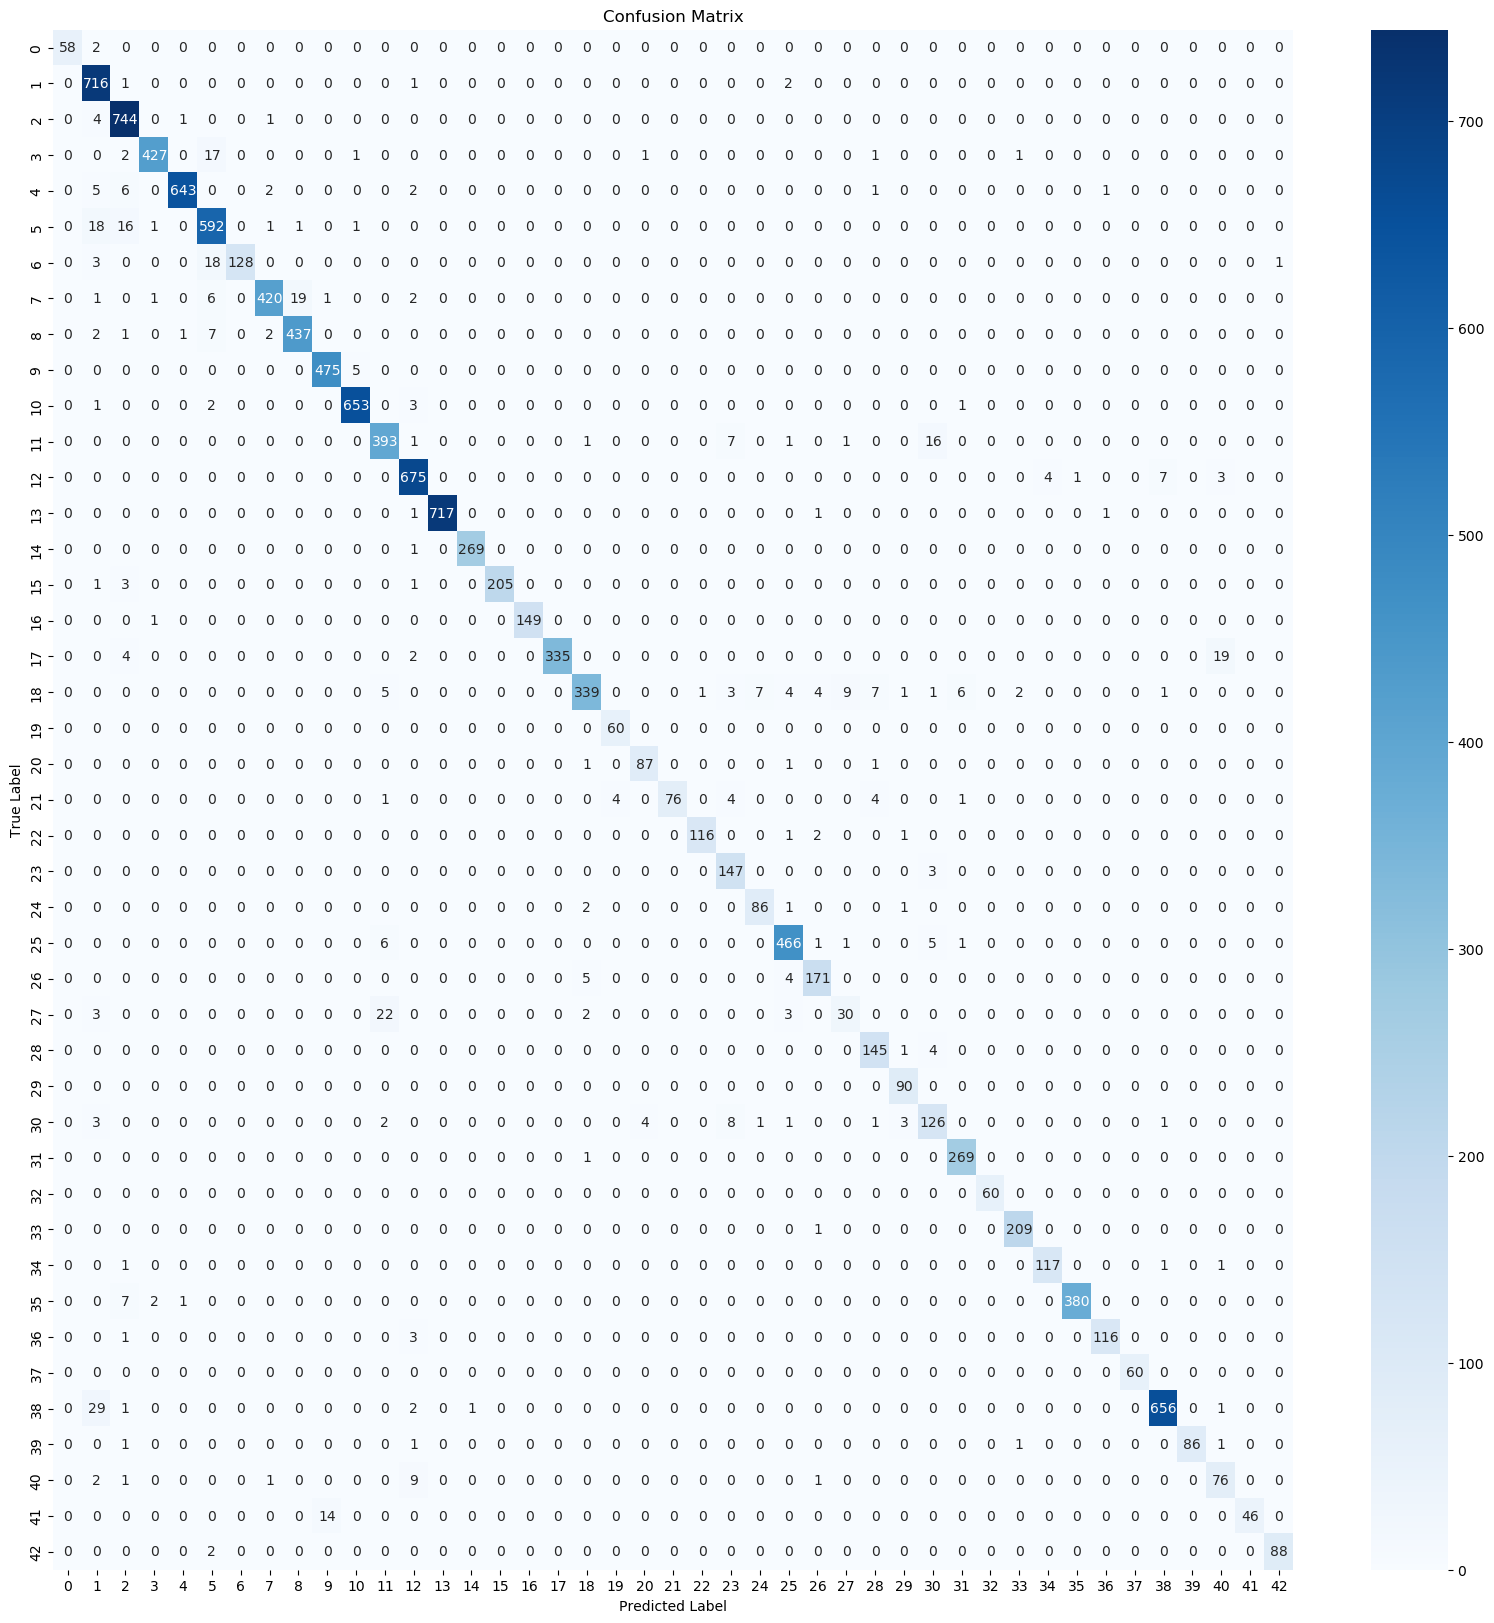

In [242]:
# 可視化混淆矩陣
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()